<a href="https://colab.research.google.com/github/Santhoshnov/FoliageMed/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

In [ ]:
df_train= "/content/tomato/train"
df_test= "/content/tomato/val"

In [ ]:
len(df_train)

32

In [ ]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    df_train,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


dataset_test = tf.keras.preprocessing.image_dataset_from_directory(
    df_test,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 10000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.


In [ ]:
class_names = dataset_train.class_names
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [ ]:
for image_batch, labels_batch in dataset_train.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[5 0 0 2 3 6 6 4 6 4 0 3 4 0 1 5 7 5 2 8 3 6 8 3 2 4 0 7 8 6 1 5]


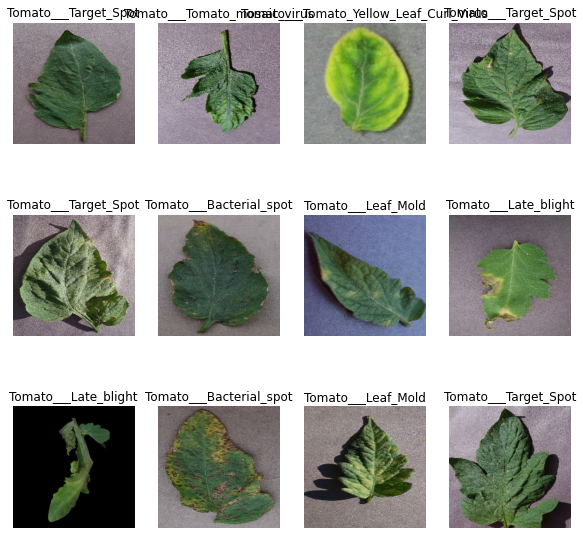

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset_train.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset_train)

313

In [ ]:
def get_dataset_partitions_tf(df,
                         train_split=0.8, val_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split  + val_split) == 1

    ds_size = len(df)

    if shuffle:
        df= df.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds =df.take(train_size)
    val_ds = df.skip(train_size).take(val_size)

    return train_ds, val_ds

In [ ]:
train_ds, val_ds = get_dataset_partitions_tf(dataset_train)

In [ ]:
len(train_ds)

250

In [ ]:
len(val_ds)

62

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
dataset_test = dataset_test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
data_scaling = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),0
  layers.experimental.preprocessing.RandomContrast(0.5),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2)

])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    data_scaling,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    dataset_train,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/20
313/313 [==============================] - 36s 90ms/step - loss: 1.6417 - accuracy: 0.3844 - val_loss: 1.4612 - val_accuracy: 0.4869
Epoch 2/20
313/313 [==============================] - 15s 49ms/step - loss: 1.0113 - accuracy: 0.6391 - val_loss: 0.8304 - val_accuracy: 0.6966
Epoch 3/20
313/313 [==============================] - 15s 48ms/step - loss: 0.7637 - accuracy: 0.7301 - val_loss: 0.6047 - val_accuracy: 0.7833
Epoch 4/20
313/313 [==============================] - 15s 48ms/step - loss: 0.5834 - accuracy: 0.7969 - val_loss: 0.6166 - val_accuracy: 0.7828
Epoch 5/20
313/313 [==============================] - 15s 48ms/step - loss: 0.4989 - accuracy: 0.8250 - val_loss: 0.4061 - val_accuracy: 0.8564
Epoch 6/20
313/313 [==============================] - 15s 49ms/step - loss: 0.4334 - accuracy: 0.8463 - val_loss: 0.3574 - val_accuracy: 0.8755
Epoch 7/20
313/313 [==============================] - 15s 49ms/step - loss: 0.3434 - accuracy: 0.8803 - val_loss: 0.2963 - val_accuracy:

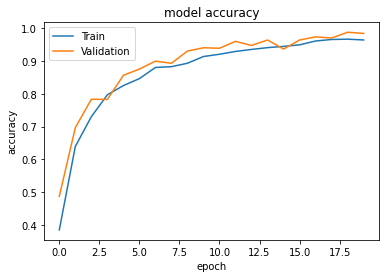

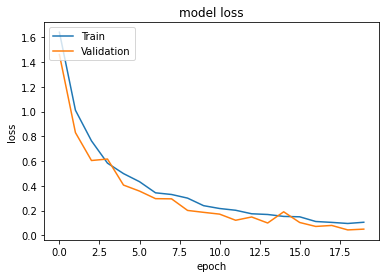

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

first image to predict
actual label: Tomato___Septoria_leaf_spot
predicted label: Tomato___Septoria_leaf_spot


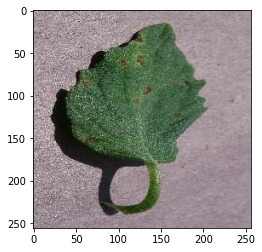

In [ ]:
#Run the predication on the first image
import numpy as np
for images_batch, labels_batch in dataset_test.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

first image to predict
actual label: Tomato___Bacterial_spot
predicted label: Tomato___Bacterial_spot


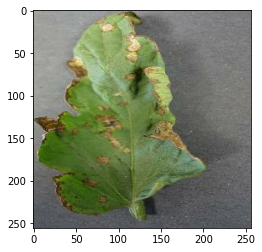

In [ ]:
#Run the predication on the first image
import numpy as np
for images_batch, labels_batch in dataset_test.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
model.save("model.h5", include_optimizer=True)